# Explore the CAZome of _Pectobacterium_ and _Dickeya_ genomes

This notebook explores the size and composition of Refseq _Pectobacterium_, _Dickeya_ and _Musicola_ CAZomes.

## Table of Contents

0. [Imports](#imports)
    * Load packages
    * Load in data
1. [CAZome size](#cazome-size)
    * Compare the number of CAZymes
    * Compare the proportion of the proteome represented by the CAZomes
2. [CAZy classes](#cazy-classes)
    * The number of CAZymes per CAZy class
    * Mean (+/- SD) number of CAZymes per CAZy class per genus
3. [CAZy families](#cazy-families)
    * Calculate CAZy family frequencies per genome
    * Plot a clustermap of CAZy family frequencies

<a id="imports"></a>
## 0. Imports

### Packages

In [1]:
!pip3 install adjusttext
!pip3 install -e /home/emmah/eastbio_storage/cazomevolve_dev/

Obtaining file:///home/emmah/eastbio_storage/cazomevolve_dev
  Preparing metadata (setup.py) ... done


  Attempting uninstall: cazomevolve
    Found existing installation: cazomevolve 0.0.3
    Uninstalling cazomevolve-0.0.3:
      Successfully uninstalled cazomevolve-0.0.3
  Running setup.py develop for cazomevolve


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from copy import copy
from matplotlib.patches import Patch
from pathlib import Path

import adjustText
import upsetplot

from Bio import SeqIO
from saintBioutils.utilities.file_io.get_paths import get_file_paths
from saintBioutils.utilities.file_io import make_output_directory
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
from cazomevolve.cazome.explore.cazome_sizes import (
    calc_proteome_representation,
    count_items_in_cazome,
    get_proteome_sizes,
)
from cazomevolve.cazome.explore.cazy_classes import calculate_class_sizes
from cazomevolve.cazome.explore.cazy_families import (
    build_fam_freq_df,
    build_row_colours
)

### Data 

Load tab delimited list of cazy families, genomes and protein accessions

Each unique protein-family pair is represented on a separate line. Therefore, a single protein can be present on multiple rows in the `gfp_df`.

In [4]:
gfp_file = "../data/pecto_dict/cazomes/pd_fam_genomes_proteins"
gfp_df = pd.read_table(gfp_file, header=None)
gfp_df.columns = ['Family', 'Genome', 'Protein']
gfp_df.head(3)

,Family,Genome,Protein
0,GH8,GCF_000365365.1,WP_024104087.1
1,GT51,GCF_000365365.1,WP_024104265.1
2,GH32,GCF_000365365.1,WP_024104299.1


Load in CSV of tax data from cazevolve_add_taxs

In [5]:
tax_csv_path = "../data/pecto_dict/cazomes/fg_genome_taxs.csv"
tax_df = pd.read_csv(tax_csv_path).drop('Unnamed: 0', axis=1)
tax_df.head(3)

,Genome,Genus,Species
0,GCF_015277635.1,Pectobacterium,aroidearum
1,GCF_016944315.1,Pectobacterium,brasiliense
2,GCF_007210685.1,Dickeya,chrysanthemi


Build dataframe of:
* CAZy family annotations
* Genomic accession
* Taxonomic infomration - splitting each taxonomy rank (i.e. ranks) into a separate column. E.g.:
    * Genus
    * Species

In [6]:
genus_col = []
species_col = []

for ri in tqdm(range(len(gfp_df)), desc="Collecting tax data"):
    tax_row = tax_df[tax_df['Genome'] == gfp_df.iloc[ri]['Genome']]
    genus_col.append(tax_row['Genus'].values[0])
    species_col.append(tax_row['Species'].values[0])
    
gfp_df['Genus'] = genus_col
gfp_df['Species'] = species_col
gfp_df.head(10)

,Family,Genome,Protein,Genus,Species
0,GH8,GCF_000365365.1,WP_024104087.1,Dickeya,dianthicola
1,GT51,GCF_000365365.1,WP_024104265.1,Dickeya,dianthicola
2,GH32,GCF_000365365.1,WP_024104299.1,Dickeya,dianthicola
3,GT4,GCF_000365365.1,WP_024104472.1,Dickeya,dianthicola
4,GT4,GCF_000365365.1,WP_024104473.1,Dickeya,dianthicola
5,GH43,GCF_000365365.1,WP_024104700.1,Dickeya,dianthicola
6,GT1,GCF_000365365.1,WP_024104746.1,Dickeya,dianthicola
7,PL4,GCF_000365365.1,WP_024104792.1,Dickeya,dianthicola
8,CBM63,GCF_000365365.1,WP_024104808.1,Dickeya,dianthicola
9,GH23,GCF_000365365.1,WP_024104833.1,Dickeya,dianthicola


<a id="cazome-size"> </a>
## 1. CAZome size

Calculate the number of CAZymes per genome (defined as the number of unique protein accessions per genome).

In total, calculate:
* The number of CAZymes per genome
* The mean number of CAZymes per genome per genus
* The proportion of the proteome represented by the CAZome
* The mean proportion of the proteome represented by the CAZome

Use the `count_items_in_cazome()` function to retrieve the number of CAZymes and the number of CAZy families per genome, and the mean counts per genus.

In [7]:
help(count_items_in_cazome)

Help on function count_items_in_cazome in module cazomevolve.cazome.explore.cazome_sizes:

count_items_in_cazome(gfp_df, item, grp, round_by=None)
    Count the number of unique items per genome and per specificed tax grouping
    
    :param gfp_df: panda df, cols = ['Family', 'Genome', 'Protein', 'tax grp', 'tax grp'...]
    :param item: str, name of column to calculate incidence for, e.g. 'Protein' or 'Family'
    :param grp: str, name of column to group genomes by
    :param round_by: int, number of figures to round mean and sd by. If None do not round
    
    Return
    * dict of {grp: {genome: {'items': {items}, 'numOfItems': int(num of items)}}}
    * df, cols = []



In [8]:
# Calculate CAZymes per genome
cazome_sizes_dict, cazome_sizes_df = count_items_in_cazome(gfp_df, 'Protein', 'Genus', round_by=2)
cazome_sizes_df

Gathering CAZy families per genome: 100%|███████████████████████████████████████████| 28371/28371 [00:03<00:00, 8725.86it/s]
Calculating num of Protein per genome and per Genus: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 1799.87it/s]


,Genus,MeanProteins,SdProteins,NumOfGenomes
0,Dickeya,98.93,6.55,92
1,Pectobacterium,97.62,6.01,188
2,Hafnia,75.00,0.00,1


In [9]:
# Calculate CAZy families per genome
cazome_fam_dict, cazome_fams_df = count_items_in_cazome(gfp_df, 'Family', 'Genus', round_by=2)
cazome_fams_df

Gathering CAZy families per genome: 100%|███████████████████████████████████████████| 28371/28371 [00:03<00:00, 7241.15it/s]
Calculating num of Family per genome and per Genus: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 1938.52it/s]


,Genus,MeanFamilys,SdFamilys,NumOfGenomes
0,Dickeya,53.09,2.66,92
1,Pectobacterium,54.32,2.41,188
2,Hafnia,40.00,0.00,1


In [10]:
# Get the size of the proteome (the number of protein acc) per genome
grp = 'Genus'
proteome_dir = "/home/emmah/eastbio_storage/eastbio_pecto_dickeya/proteomes"
proteome_dict = get_proteome_sizes(proteome_dir, gfp_df, grp)

Getting proteome sizes: 100%|█████████████████████████████████████████████████████████████| 281/281 [00:13<00:00, 21.24it/s]


In [11]:
# Calculate the mean proteome size by genus and the proportion of the proteome represented by the CAZome
proteome_perc_df = calc_proteome_representation(proteome_dict, cazome_sizes_dict, grp, round_by=2)
proteome_perc_df

Calc proteome perc: 100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1170.83it/s]


,Genus,MeanProteomeSize,SdProteomeSize,MeanProteomePerc,SdProteomePerc,NumOfGenomes
0,Dickeya,4102.53,142.95,2.41,0.09,92
1,Pectobacterium,4207.19,189.81,2.32,0.09,188
2,Hafnia,4297.00,0.00,1.75,0.00,1


<a id="cazy-classes"> </a>
## 2. CAZy classes

Calculate the number of CAZymes (identified as the number of unique protein accessions) per CAZy class. Also, calculate mean size of CAZy classes per genus.

The dataframe of the data is written to `results/pecto_dic/cazy_class_sizes.csv`, and was used to generate a proportiona area plot using [RawGraphs](https://app.rawgraphs.io/).

In [12]:
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/pecto_dic'), force=True, nodelete=True)

class_df, class_size_dict = calculate_class_sizes(gfp_df, grp, round_by=2)
class_df.to_csv('../results/pecto_dic/cazy_class_sizes.csv')
class_df

Output directory ../results/pecto_dic exists, nodelete is True. Adding output to output directory.
Calculating CAZy class sizes: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 688.42it/s]


,CAZyClass,Genus,MeanCazyClass,SdCazyClass,NumOfGenomes
0,GH,Dickeya,41.184783,3.556774,92
1,GH,Pectobacterium,47.409574,2.827922,188
2,GH,Hafnia,41.000000,0.000000,1
3,GT,Dickeya,35.336957,2.691683,92
4,GT,Pectobacterium,28.058511,3.016229,188
5,GT,Hafnia,31.000000,0.000000,1
6,PL,Dickeya,15.532609,1.715980,92
7,PL,Pectobacterium,14.170213,1.276950,188
8,PL,Hafnia,1.000000,0.000000,1
9,CE,Dickeya,6.000000,0.691564,92


<a id="cazy-families"> </a>
## 3. CAZy families

Calculate the number of CAZymes per CAZy family presented in each genome, where the number of CAZymes is the number of unqiue protein accessions. This value may be greater than the number of CAZymes in the genome because a CAZyme may be annotated with multiple CAZy families.

In [13]:
fam_freq_df = build_fam_freq_df(gfp_df, ['Genus', 'Species'])
fam_freq_df

The dataset contains 90 CAZy families


Counting fam frequencies: 100%|███████████████████████████████████████████████████████████| 281/281 [00:14<00:00, 19.28it/s]


,Genome,Genus,Species,AA10,AA3,CBM13,CBM3,CBM32,CBM34,CBM4,...,PL1,PL10,PL11,PL17,PL2,PL22,PL26,PL3,PL4,PL9
0,GCF_002904105.1,Pectobacterium,carotovorum,0,0,1,0,1,0,0,...,6,0,1,0,2,1,1,2,1,2
1,GCF_005497185.1,Pectobacterium,polonicum,0,0,1,0,1,0,0,...,6,0,0,0,2,1,1,2,1,2
2,GCF_000406245.1,Dickeya,chrysanthemi,0,0,0,0,0,0,0,...,6,1,0,0,1,1,1,2,2,3
3,GCF_018361065.1,Dickeya,dianthicola,0,0,0,0,0,0,0,...,6,0,0,0,1,1,1,2,2,3
4,GCF_002846975.1,Dickeya,solani,0,0,0,0,0,0,0,...,7,0,0,0,1,1,1,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,GCF_000808455.1,Pectobacterium,brasiliense,0,0,1,1,1,0,0,...,6,0,0,0,2,1,0,2,1,2
277,GCF_016950185.1,Pectobacterium,brasiliense,0,0,1,1,1,0,0,...,6,0,0,0,2,1,0,2,1,2
278,GCF_000808375.1,Pectobacterium,brasiliense,0,0,0,1,1,0,0,...,6,0,0,0,2,1,0,2,1,2
279,GCF_009931295.1,Pectobacterium,carotovorum,0,0,0,0,1,0,0,...,5,0,0,0,2,1,1,2,1,2


Build clustermap of CAZy family frequencies, with additional row colours marking the genus classification of each genome (i.e. each row).

In this case, also exclude the _Hafnia_ genome because it was used as an out group for the phylogenetic tree.

In [14]:
# Drop Hafnia genome
fam_freq_df_pd = copy(fam_freq_df)
fam_freq_df_pd = fam_freq_df_pd[fam_freq_df_pd['Genus'] != 'Hafnia']

In [15]:
fam_freq_df_pd.head(1)

,Genome,Genus,Species,AA10,AA3,CBM13,CBM3,CBM32,CBM34,CBM4,...,PL1,PL10,PL11,PL17,PL2,PL22,PL26,PL3,PL4,PL9
0,GCF_002904105.1,Pectobacterium,carotovorum,0,0,1,0,1,0,0,...,6,0,1,0,2,1,1,2,1,2


Additionally, index `fam_freq_df` so that each row name contains the genome, Genus and Species, so that the genomic accession, genus and species is included in the clustermap.

In [16]:
# index the taxonomy data and genome (ggs=genome_genus_species)
fam_freq_df_ggs = copy(fam_freq_df_pd)  # so does not alter fam_freq_df
fam_freq_df_ggs = fam_freq_df_ggs.set_index(['Genome','Genus','Species'])
fam_freq_df_ggs.head(1)

,,,AA10,AA3,CBM13,CBM3,CBM32,CBM34,CBM4,CBM48,CBM5,CBM63,...,PL1,PL10,PL11,PL17,PL2,PL22,PL26,PL3,PL4,PL9
Genome,Genus,Species,,,,,,,,,,,,,,,,,,,,,
GCF_002904105.1,Pectobacterium,carotovorum,0,0,1,0,1,0,0,2,0,1,...,6,0,1,0,2,1,1,2,1,2


Define a colour scheme to colour code the rows by, in this case by the genus of the species.

To do this, add a column containing the data to be used to colour code each row, e.g. a genus. This extra column is removed by `build_row_colours()`. The dataframe that is parsed to `build_row_colours()` must be the dataframe that is used to generate a clustermap, otherwise Seaborn will not be able to map the row oclours correctly and no row colours will be produced.

In [17]:
# define a colour scheme to colour code rows by genus
fam_freq_df_ggs['Genus'] = list(fam_freq_df_pd['Genus'])  # add column to use for colour scheme, is removed
fam_freq_genus_row_colours, fam_g_lut = build_row_colours(fam_freq_df_ggs, 'Genus', 'Set2')

Build a clustermap of CAZy family frequencies.

In [30]:
help(build_family_clustermap)

Help on function build_family_clustermap in module __main__:

build_family_clustermap(df, row_colours=None, fig_size=None, file_path=None, file_format='png', font_scale=1, dpi=300, dendrogram_ratio=None, lut=None, legend_title='', title_fontsize='2', legend_fontsize='2', bbox_to_anchor=(1, 1), cmap=<matplotlib.colors.ListedColormap object at 0x7fa605f1edf0>)
    Build a clustermap of the CAZy family frequencies per genome
    
    :param df: df of CAZy family frequencies per genome
    :param row_colours: pandas map - used to define additional row colours. or list of maps for 
        multiple sets of row colours. If None, additional row colours are not plotted
    :param fig_size: tuple (width, height) of final figure. If None, decided by Seaborn
    :param file_path: path to save image to. If None, the figure is not written to a file
    :param file_format: str, file format to save figure to. Default 'png'
    :param font_scale: int, scale text - use if text is overlapping. <1 to red

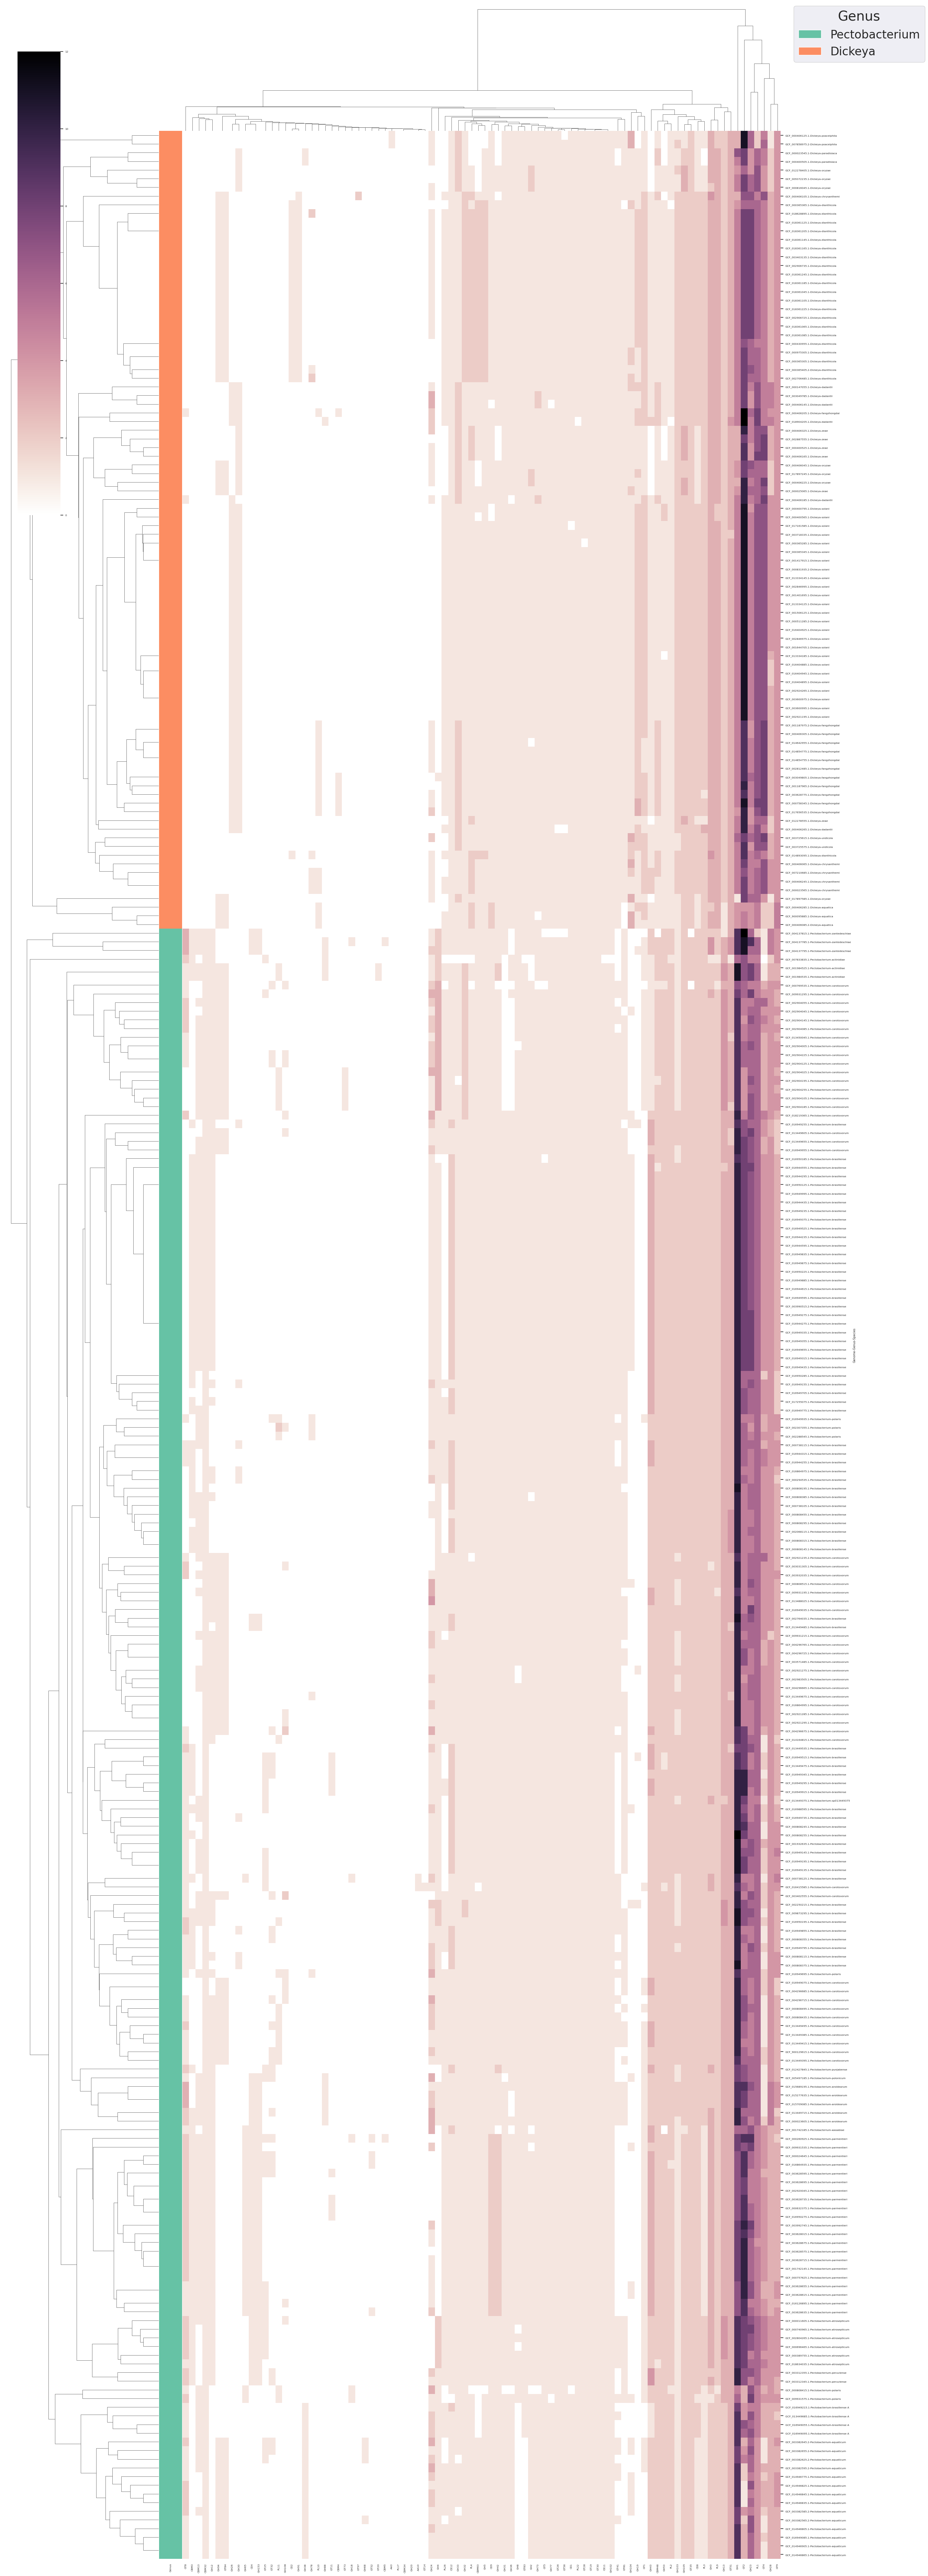

In [29]:
# make a figure that is full size, and all data is legible
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(25,73),
    file_path="../results/pecto_dic/pd_fam_freq_clustermap.svg",
    file_format='svg',
    font_scale=0.5,
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.2,0.05),
    title_fontsize=28,
    legend_fontsize=24,
)

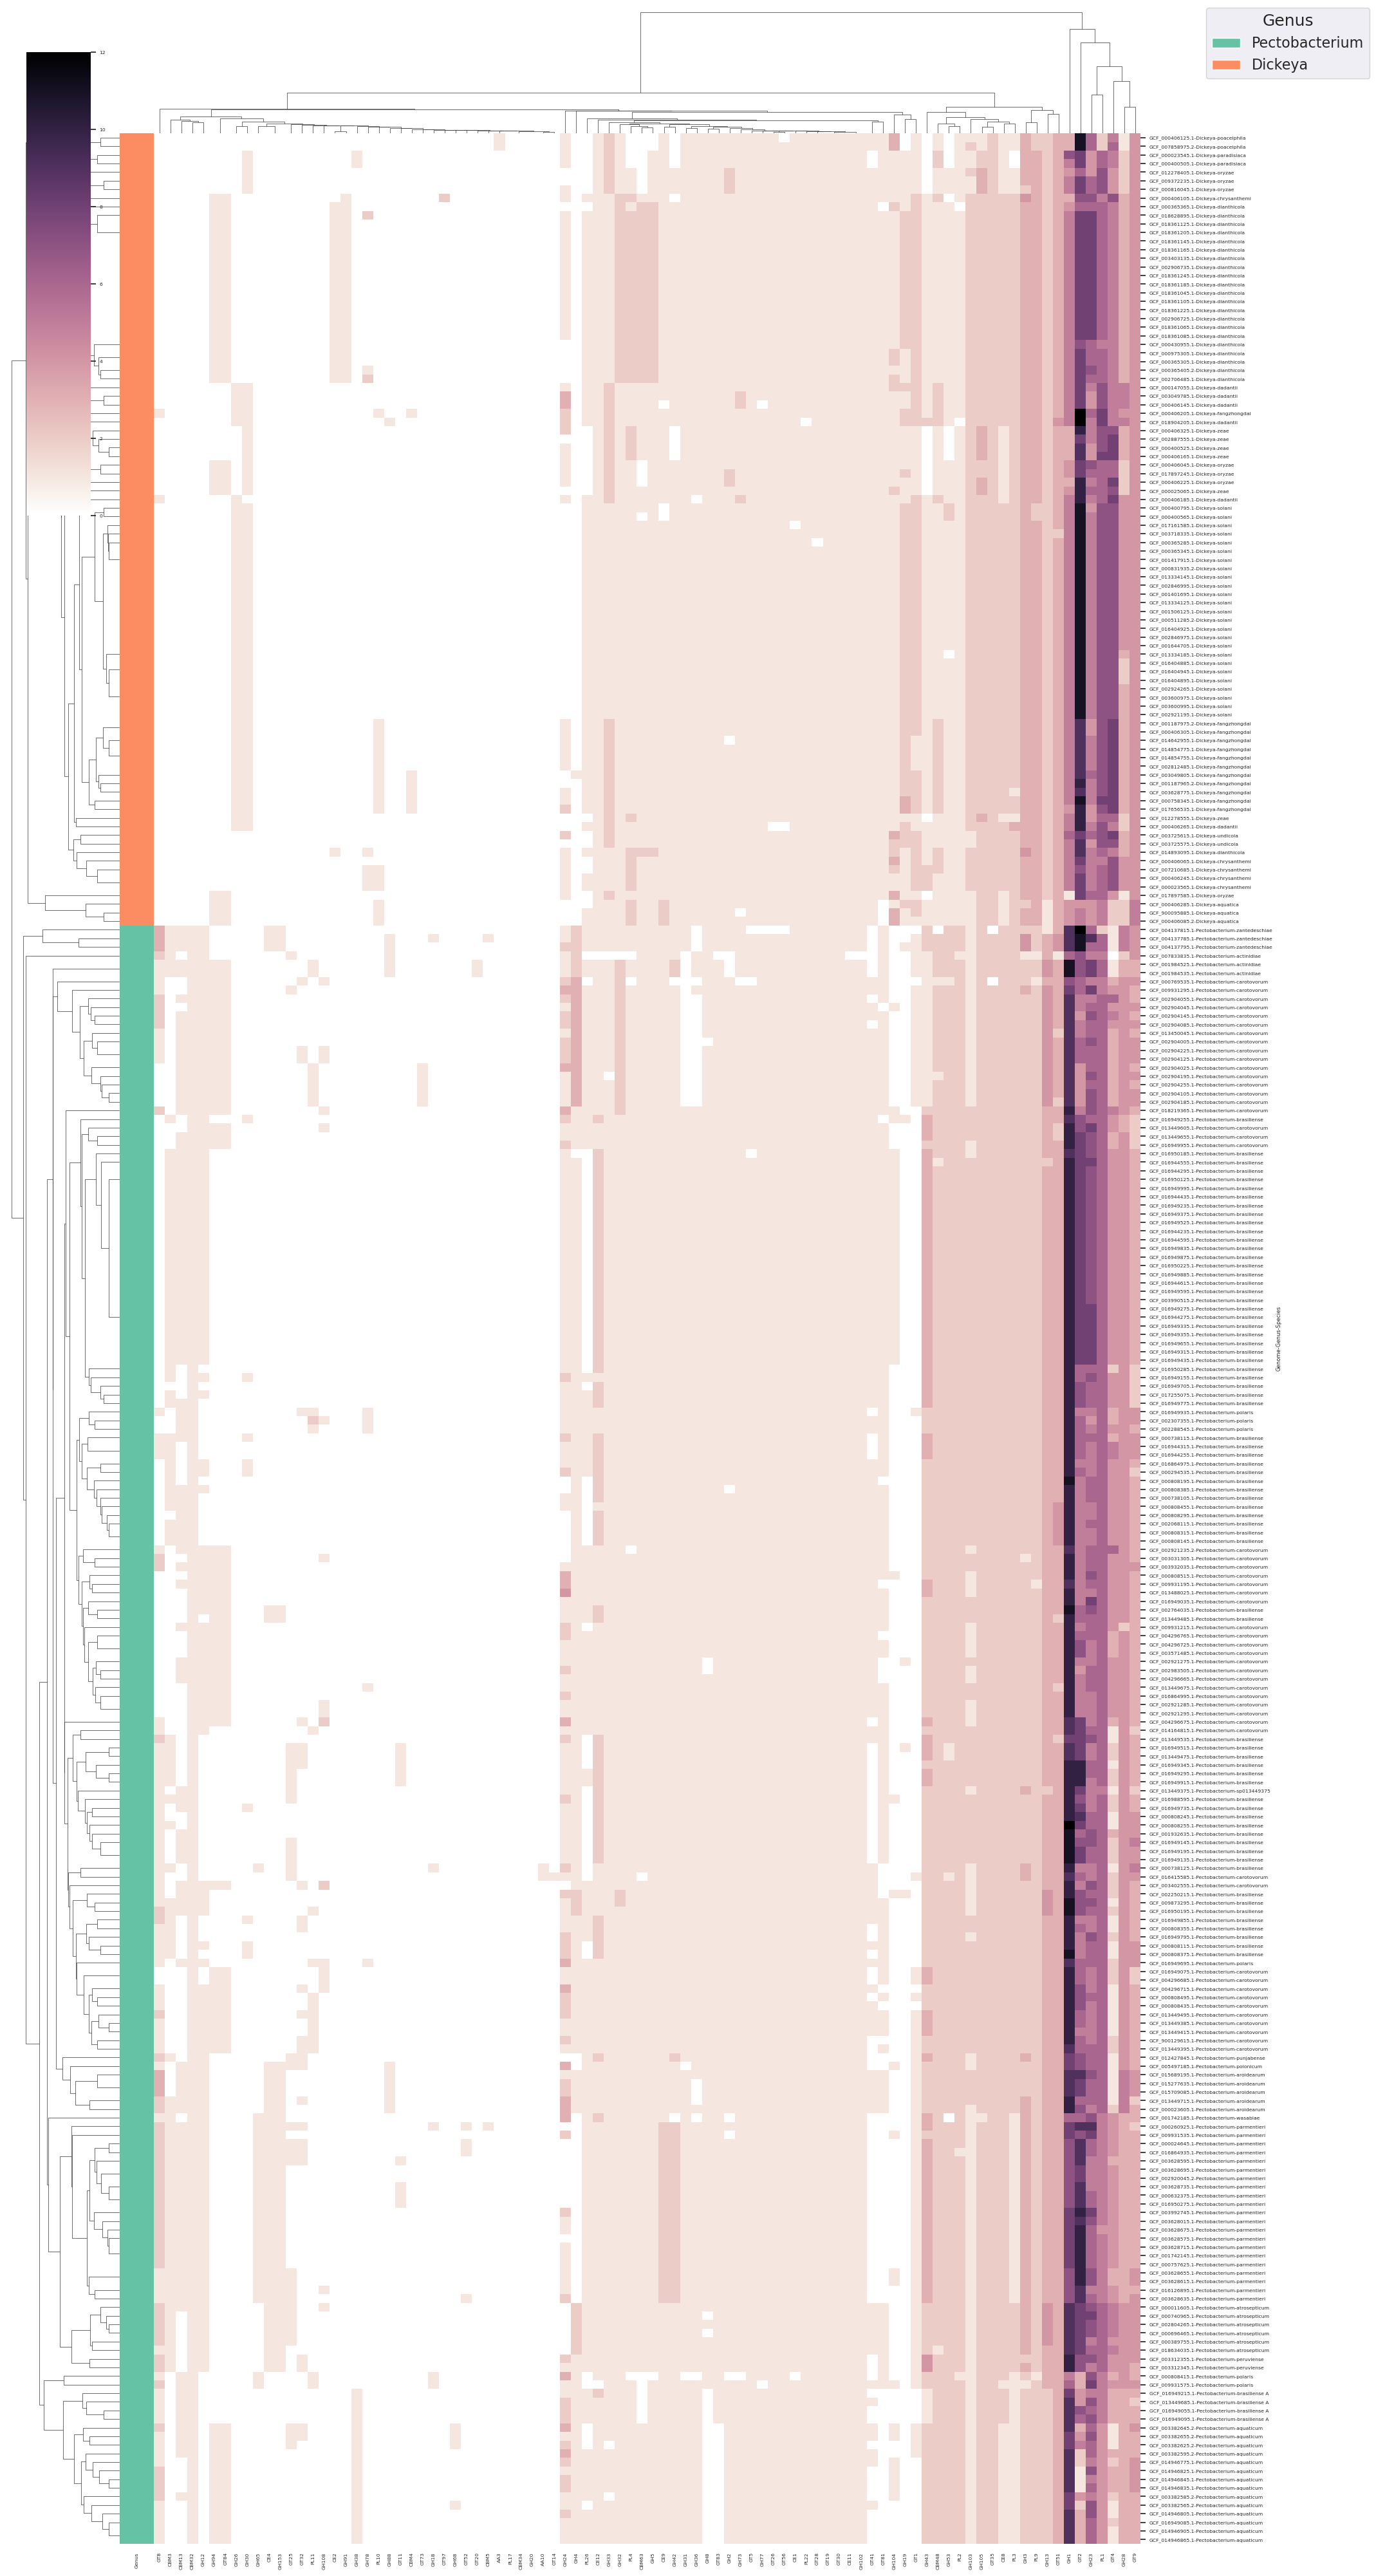

In [34]:
# make a figure the optimal size to fit in a paper
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(20,40),
    file_path="../results/pecto_dic/paper_pd_fam_freq_clustermap.png",
    file_format='png',
    font_scale=0.5,
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
)

## 4. The Core CAZome

Identify CAzy families that are present in every genome in the dataset. These families form the 'core CAZome'.

## 5. Families that always occur together